In [8]:
import tensorflow as tf

import tensorflow.keras
import tensorflow.keras.layers
import tensorflow.keras.models 
import tensorflow.keras.regularizers 
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import glob as glob
import numpy as np
import os
from datetime import datetime
import time


from sklearn.model_selection import train_test_split, KFold, cross_val_score

In [9]:
# define constants
BATCH_SIZE = 5
image_size = [250, 250] # defines the scaling of the images (with padding) and the shape of the first NN layer
num_channels = 1

In [10]:
# https://towardsdatascience.com/implementing-a-resnet-model-from-scratch-971be7193718
class ResNet:
    @staticmethod
    def residual_module(data, K, stride, chanDim, red=False, 
        reg=0.0001, bnEps=2e-5, bnMom=0.9):
        shortcut = data
  
        # the first block of the ResNet module are the 1x1 CONVs
        bn1 = tf.keras.layers.BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(data)
        act1 = tf.keras.layers.Activation("relu")(bn1)
        conv1 = tf.keras.layers.Conv2D(int(K * 0.25), (1, 1), use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(reg))(act1)
        
        # the second block of the ResNet module are the 3x3 CONVs
        bn2 = tf.keras.layers.BatchNormalization(axis=chanDim, epsilon=bnEps, momentum=bnMom)(conv1)
        act2 = tf.keras.layers.Activation("relu")(bn2)
        conv2 = tf.keras.layers.Conv2D(int(K * 0.25), (3, 3), strides=stride, padding="same", use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(reg))(act2)
                       
        # the third block of the ResNet module is another set of 1x1 CONVs
        bn3 = tf.keras.layers.BatchNormalization(axis=chanDim, epsilon=bnEps,momentum=bnMom)(conv2)
        act3 = tf.keras.layers.Activation("relu")(bn3)
        conv3 = tf.keras.layers.Conv2D(K, (1, 1), use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(reg))(act3)

        # if we are to reduce the spatial size, apply a CONV layer to the shortcut
        if red:
            shortcut = tf.keras.layers.Conv2D(K, (1, 1), strides=stride, use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(reg))(act1)

        # add together the shortcut and the final CONV
        x = tf.keras.layers.add([conv3, shortcut])

        # return the addition as the output of the ResNet module
        return x

    @staticmethod
    def build(width, height, depth, classes, stages, filters, 
        reg=0.0001, bnEps=2e-5, bnMom=0.9):
        # initialize the input shape to be "channels last" and the
        # channels dimension itself
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1
                       
        # set the input and apply BN
        inputs = tf.keras.Input(shape=inputShape)
        x = tf.keras.layers.BatchNormalization(axis=chanDim, epsilon=bnEps,
            momentum=bnMom)(inputs)

        # apply CONV => BN => ACT => POOL to reduce spatial size
        x = tf.keras.layers.Conv2D(filters[0], (7, 7), use_bias=False,
            padding="same", kernel_regularizer=tf.keras.regularizers.l2(reg))(x)
        x = tf.keras.layers.BatchNormalization(axis=chanDim, epsilon=bnEps,
            momentum=bnMom)(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.ZeroPadding2D((1, 1))(x)
        x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
            
        # loop over the number of stages
        for i in range(0, len(stages)):
            # initialize the stride, then apply a residual module
            # used to reduce the spatial size of the input volume
            stride = (1, 1) if i == 0 else (2, 2)
            x = ResNet.residual_module(x, filters[i + 1], stride,
                    chanDim, red=True, bnEps=bnEps, bnMom=bnMom)

            # loop over the number of layers in the stage
            for j in range(0, stages[i] - 1):
                # apply a ResNet module
                x = ResNet.residual_module(x, filters[i + 1],
                    (1, 1), chanDim, bnEps=bnEps, bnMom=bnMom)
        
        # apply BN => ACT => POOL
        x = tf.keras.layers.BatchNormalization(axis=chanDim, epsilon=bnEps,
                momentum=bnMom)(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.AveragePooling2D((8, 8))(x)
                       
        # softmax classifier
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(classes, kernel_regularizer=tf.keras.regularizers.l2(reg))(x)
        x = tf.keras.layers.Activation("softmax")(x)

        # create the model
        model = tf.keras.Model(inputs, x, name="resnet")

        # return the constructed network architecture
        return model

In [11]:
model = ResNet.build(image_size[0], image_size[1], 1, 2, [3, 4, 6, 3], [64, 64, 128, 256, 512])

In [12]:
# read images from file path
def load_images(path, type='*.tiff'):
    files = glob.glob(path + type)
    imgs = []
    for file in files:
        imgs.append(load_and_preprocess_image(file))
    return imgs

# normalize intensity values
def preprocess_image(image):
    image = image[:, :, :3] # discard alpha channel
    image = tf.image.rgb_to_grayscale(image) 
    image = image / np.iinfo(np.uint8).max 
    
    return image

def load_and_preprocess_image(path):
    image = plt.imread(path)
    return preprocess_image(image)

In [13]:
# load dataset
data_location = './dataset/sorted/'
ok_path = data_location + 'ok/'
damaged_path = data_location + 'damaged/'

ok_imgs = load_images(ok_path)
damaged_imgs = load_images(damaged_path)

In [14]:
def fuse_dataset(*list):
    index = 0
    train_imgs = []
    train_labels = []
    for group in list:
        train_imgs.extend(group)
        train_labels.extend([index] * len(group))
        index = index+1
    return train_imgs, train_labels

label_names = ['ok','damaged']
(X, y) = fuse_dataset(ok_imgs, damaged_imgs)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [15]:
def plot_preped_img(image):
    plt.imshow(tf.squeeze((image+1)/2), cmap='gray')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
def preprocess(image):
    img = tf.image.random_contrast(image, 0.8, 1.8)
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.compat.v2.image.resize(img, size=image_size)
    return img

In [16]:
image_ds = tf.data.Dataset.from_generator(lambda: (preprocess(X_train[i]) for i in range(len(X_train))), tf.float32, output_shapes=[image_size[0],image_size[1],num_channels])
label_ds = tf.data.Dataset.from_generator(lambda: (y_train[i] for i in range(len(y_train))), tf.int32, output_shapes=[])

ds = tf.data.Dataset.zip((image_ds, label_ds))
ds = ds.shuffle(buffer_size=len(X), reshuffle_each_iteration=True).repeat()
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Displaying 101 images.


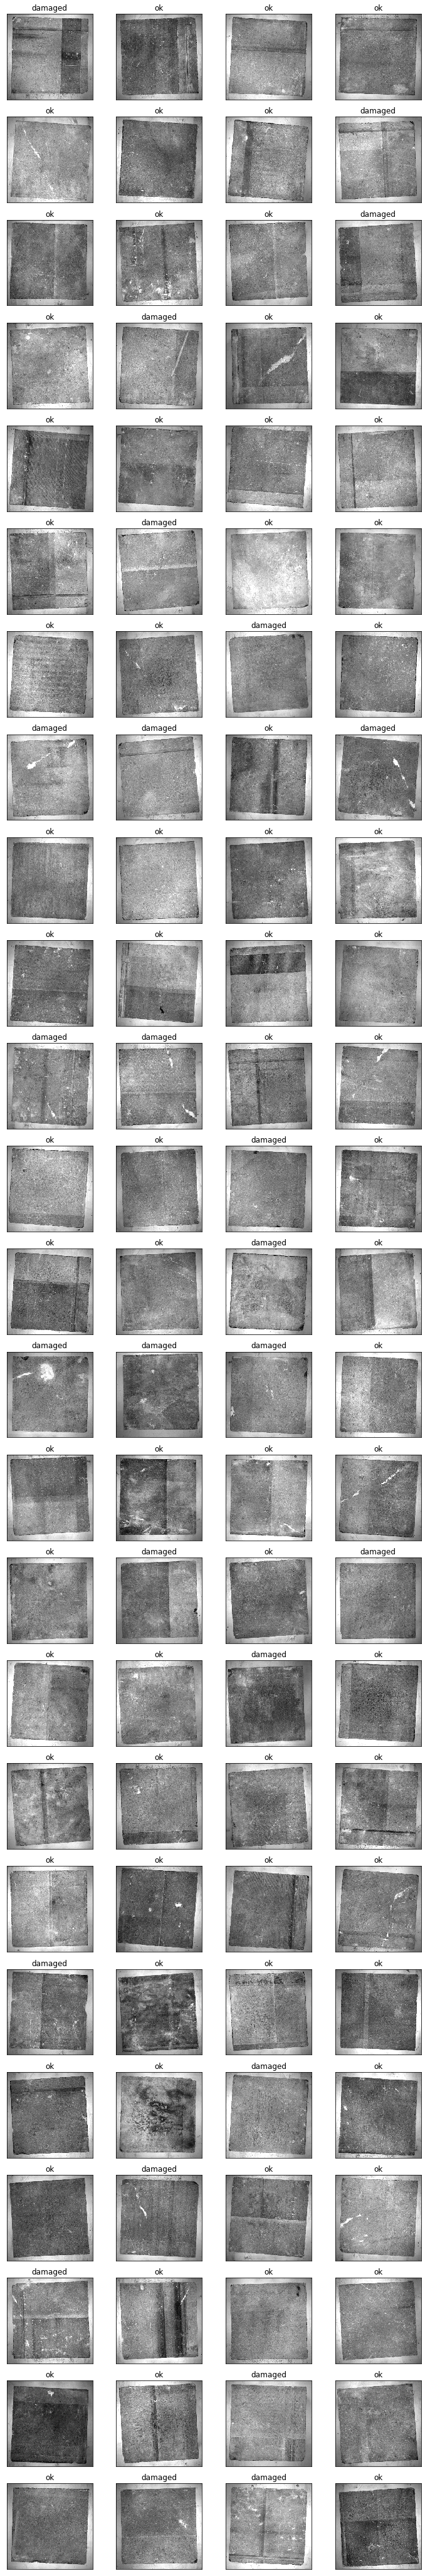

In [17]:
ikd = iter(ds)
columns = 4
rows = 5 * BATCH_SIZE
image_side = 3
fig=plt.figure(figsize=(columns*image_side, rows*image_side))
print("Displaying", columns*rows +1, "images.")
for i in range(1, columns*rows +1, BATCH_SIZE):
    image_batch, label_batch = next(ikd)
    for j in range(BATCH_SIZE):
        fig.add_subplot(rows, columns, i+j)
        plot_preped_img(image_batch[j])
        label = label_names[label_batch[j]]
        plt.title(label)
        # plt.axis('off')
plt.show()

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])
model.summary()

Model: "resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 250, 250, 1) 0                                            
__________________________________________________________________________________________________
batch_normalization_51 (BatchNo (None, 250, 250, 1)  4           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 250, 250, 64) 3136        batch_normalization_51[0][0]     
__________________________________________________________________________________________________
batch_normalization_52 (BatchNo (None, 250, 250, 64) 256         conv2d_53[0][0]                  
_____________________________________________________________________________________________

In [19]:
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.time_start = time.time()
        self.time_total = 0

    def on_train_end(self, logs={}):
        self.time_total = time.time() - self.time_start

In [20]:
time_stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir="./output/logs/fit/" + time_stamp
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
time_callback = TimeHistory()

history = model.fit(ds, epochs=20, steps_per_epoch=len(y_train)//BATCH_SIZE, callbacks=[tensorboard_callback, time_callback])
print ("Total time [min]", time_callback.time_total/60)

Train for 29 steps
Epoch 1/20
29/29 [==============================] - 37s 1s/step - loss: 1.3274 - accuracy: 0.5586
Epoch 2/20
29/29 [==============================] - 30s 1s/step - loss: 1.2629 - accuracy: 0.6069
Epoch 3/20
29/29 [==============================] - 26s 902ms/step - loss: 1.2166 - accuracy: 0.6207
Epoch 4/20
29/29 [==============================] - 26s 883ms/step - loss: 1.1622 - accuracy: 0.6414
Epoch 5/20
29/29 [==============================] - 25s 875ms/step - loss: 1.1053 - accuracy: 0.6552
Epoch 6/20
29/29 [==============================] - 26s 886ms/step - loss: 1.0781 - accuracy: 0.6897
Epoch 7/20
29/29 [==============================] - 26s 882ms/step - loss: 1.0691 - accuracy: 0.6759
Epoch 8/20
29/29 [==============================] - 26s 882ms/step - loss: 1.0328 - accuracy: 0.6552
Epoch 9/20
29/29 [==============================] - 26s 883ms/step - loss: 1.1460 - accuracy: 0.6207
Epoch 10/20
29/29 [==============================] - 26s 886ms/step - loss: 1.

In [21]:
ext = '.h5'
filename = './output/damage_model_'+time_stamp+ext

model.save(filename) # save model and weights

In [22]:
# TODO fix split of square image to ensure that the windows have the same size
#X_test_new = []
#for i in range(len(X_test)):
#    X_test_new.append(tf.compat.v2.image.resize_with_pad(X_test[i], target_height=image_size[0], target_width=image_size[1]))

#X_test = X_test_new

In [23]:
# Evaluate
test_ds = tf.convert_to_tensor(X_test)
test_ds = tf.compat.v2.image.resize_with_pad(test_ds, target_height=image_size[0], target_width=image_size[1])

prediction = model.predict(test_ds, batch_size=BATCH_SIZE)
predicted_class = list(map(lambda x: np.argmax(x), prediction))

pred_vs_true = list(zip((label_names[i] for i in predicted_class), (label_names[i] for i in y_test)))
accuracy = sum(1 if i==j else 0 for i, j in pred_vs_true) / len(X_test)
print (accuracy)

0.7368421052631579


In [27]:
pred_vs_true

[('ok', 'ok'),
 ('ok', 'ok'),
 ('ok', 'damaged'),
 ('ok', 'damaged'),
 ('ok', 'ok'),
 ('ok', 'ok'),
 ('ok', 'ok'),
 ('ok', 'ok'),
 ('ok', 'damaged'),
 ('ok', 'damaged'),
 ('ok', 'ok'),
 ('damaged', 'damaged'),
 ('damaged', 'damaged'),
 ('ok', 'ok'),
 ('ok', 'ok'),
 ('ok', 'damaged'),
 ('ok', 'damaged'),
 ('ok', 'ok'),
 ('ok', 'ok'),
 ('ok', 'ok'),
 ('ok', 'damaged'),
 ('ok', 'ok'),
 ('ok', 'ok'),
 ('ok', 'damaged'),
 ('ok', 'ok'),
 ('ok', 'ok'),
 ('ok', 'ok'),
 ('ok', 'damaged'),
 ('ok', 'ok'),
 ('ok', 'ok'),
 ('ok', 'ok'),
 ('ok', 'ok'),
 ('ok', 'ok'),
 ('ok', 'ok'),
 ('ok', 'damaged'),
 ('ok', 'ok'),
 ('ok', 'ok'),
 ('ok', 'ok')]

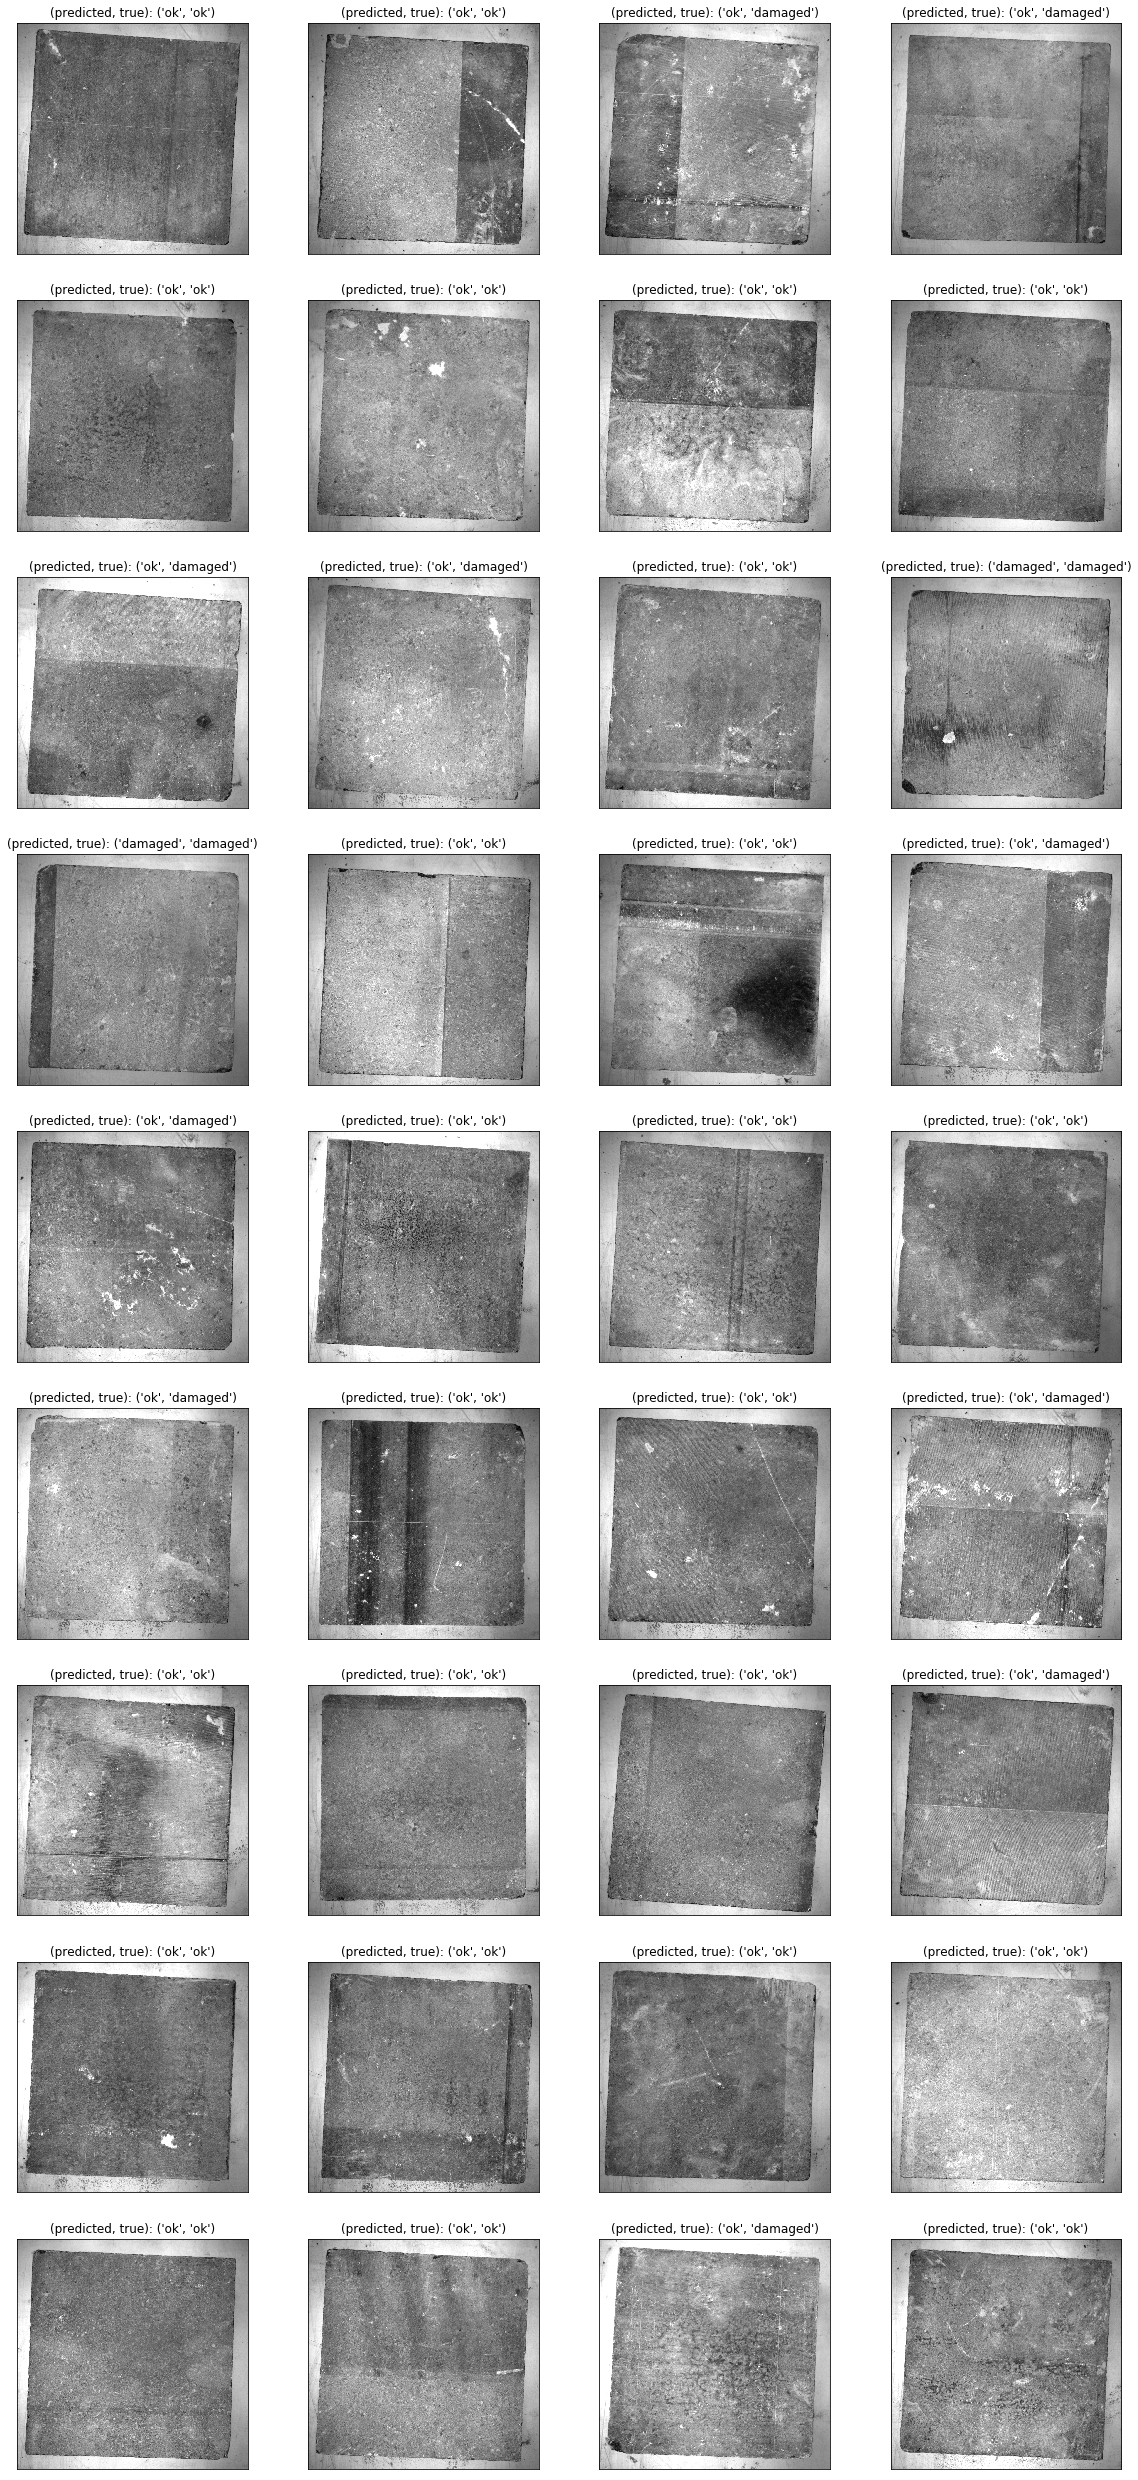

In [24]:
cols = 4
rows = len(prediction) // cols
index = 1

comp_fig = plt.figure(figsize=(cols*5, rows*5))

for row in range(rows):
    for col in range(cols):
        comp_fig.add_subplot(rows, cols, index)
        plot_preped_img(X_test[index-1])
        plt.title(f'(predicted, true): {pred_vs_true[index-1]}')
        index += 1

plt.show()

In [25]:
print("Total time [min]", time_callback.time_total/60)

Total time [min] 8.90020747979482
